<a href="https://colab.research.google.com/github/johanjun/dacon_molit/blob/main/%EB%85%B8%ED%8A%B8%EB%B6%81%EB%A6%B4%EB%A0%88%EC%9D%B4_v2(%EC%A1%B0%ED%8C%80%EC%9E%A5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 제목, 이륜차에 집중할 지 좀 더 넓게 잡을지 결정

우리의 삶의 많은 부분이 온라인으로 이동했음. 온라인으로 물건을 주문하고, 음식을 배달시키면 나 대신 다른 사람이 도로를 통해서 물건을 옮겨 주는 것. 아무리 코로나가 심해도 많은 사람들이 여전히 출근을 하고 있고, 예전보다 사람이 줄긴 했지만 길에는 사람들이 많음. 도로는 여전히 사람과 물자가 오가는 통로의 역할을 하고 있음.  

사람과 물자가 잘 흐를 수 있도록 도로를 관리하는 것이 중요. 그런데 사고가 나면 도로가 멈춰설 뿐만 아니라 인명, 재산 피해가 발생함.  
기존의 도로교통 데이터 분석 사례를 보면 고속도로 중심이 많음. 아무래도 이동량이 많고 중요한 도로기도 하지만, 자동차만 존재하는 고속도로의 환경 특성상 분석이 편함. 반면 시내도로는 도로 뿐만 아니라 건물이나 보행자 등 고려해야할 것이 많음.  

그래서 우리는 이번 분석에서 시내 도로 중심의 사고 분석을 수행  

인구와 건물과 도로, 교통 데이터를 함께 활용하기 위해 비교적 손쉽게 데이터 확보가 가능한 서울특별시로 한정지어서 분석
2019년과 2020년을 비교. 도로와 건물, 인구 유동의 특성을 활용해서 사고를 설명하고 코로나로 인한 변화도 함께 설명



## 1. 교통 사고 일반 현황

`아주 무난한 교통사고 이야기`

In [ ]:
# 라이브러리 불러오기
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

f_path = "c:/Windows/Fonts/malgun.ttf"

font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)


In [ ]:
data_dir = '/content/drive/MyDrive/dacon_molit/data/'
df_acci = pd.read_csv(data_dir+'서울시 2019-2020 교통사고.csv')

In [ ]:
# 데이터 불러오기
df_acci = pd.read_csv('../data/서울시 2019-2020 교통사고.csv')
df_acci.head(3)

,사고번호,사고일시,요일,시군구,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,...,기상상태,도로형태,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도
0,2.019010e+15,2019년 1월 1일 00시,화요일,서울특별시 강서구 방화동,경상사고,0,0,1,0,차대사람 - 횡단중,...,맑음,교차로 - 교차로횡단보도내,승용,남,26세,상해없음,보행자,남,40세,경상
1,2.019010e+15,2019년 1월 1일 00시,화요일,서울특별시 구로구 고척동,경상사고,0,0,1,0,차대차 - 추돌,...,맑음,단일로 - 기타,이륜,남,23세,상해없음,승용,남,71세,경상
2,2.019010e+15,2019년 1월 1일 00시,화요일,서울특별시 서초구 서초동,경상사고,0,0,1,0,차대차 - 기타,...,맑음,기타 - 기타,승용,남,33세,상해없음,화물,남,51세,경상


In [ ]:
# 전처리 (사고일시)
df_acci['사고일시'] = pd.to_datetime(df_acci['사고일시'], format='%Y년 %m월 %d일 %H시')
df_acci['연도']     = df_acci['사고일시'].dt.year
df_acci['사고 월']  = df_acci['사고일시'].dt.month
df_acci['사고 일']  = df_acci['사고일시'].dt.day
df_acci['사고 시각']= df_acci['사고일시'].dt.hour

In [ ]:
# 전처리 (위치)
df_acci['시'] = [x.split(' ')[0] for x in df_acci['시군구']]
df_acci['구'] = [x.split(' ')[1] for x in df_acci['시군구']]
df_acci['동'] = [x.split(' ')[2] for x in df_acci['시군구']]

In [95]:
# 전처리 (연령대)
df_acci['가해운전자 연령대'] = [str(int(x.split('세')[0][0]))+'0대' if x != '미분류' else x for x in df_acci['가해운전자 연령']]
df_acci['피해운전자 연령'] = df_acci['피해운전자 연령'].replace('미분류', np.nan)
df_acci['피해운전자 연령대'] = [str(int(x.split()[0][0]))+'0대' if type(x) != float else x for x in df_acci['피해운전자 연령']]


### 1.1. 서울시 전체 교통 사고

`여기서는 서울시 전체로 범위를 넓게 잡고 연도, 사고유형, 가해운전자, 피해자(보행자 중심), 시간대 등에 따른 차고 발생량 차이를 짚어줌`



2020년의 전체 사고 건수는 2019년 3만 9천 건보다 10% 줄어든 약 3만 5천 건.

In [ ]:
# 2019, 2020 비교
df_acci.groupby('연도')['사고유형'].count()

연도
2019    39258
2020    35227
Name: 사고유형, dtype: int64

In [148]:
# 카테고리별 시각화 함수
def viz_by_category(df, x, palette='RdPu'):
  df_new = pd.DataFrame(df.groupby(['연도', x])['사고유형'].count())

  df_new['연도'] = df_new.index.get_level_values(0)
  df_new[x] = df_new.index.get_level_values(1)


  plt.figure(figsize=(18,6))
  sns.barplot(data=df_new,
              x=x,
              y='사고유형',
              hue='연도', palette=palette)
  plt.xticks(rotation=90)
  plt.ylabel('사고 건수', fontdict={'fontsize' : 15})
  plt.xlabel(x, fontdict={'fontsize' : 15})
  plt.legend(loc='best')
  plt.show()

먼저 피해운전자 차종을 보면 보행자, 승용은 줄고, '이륜', 원동기, '자건거는 오히려 증가했음

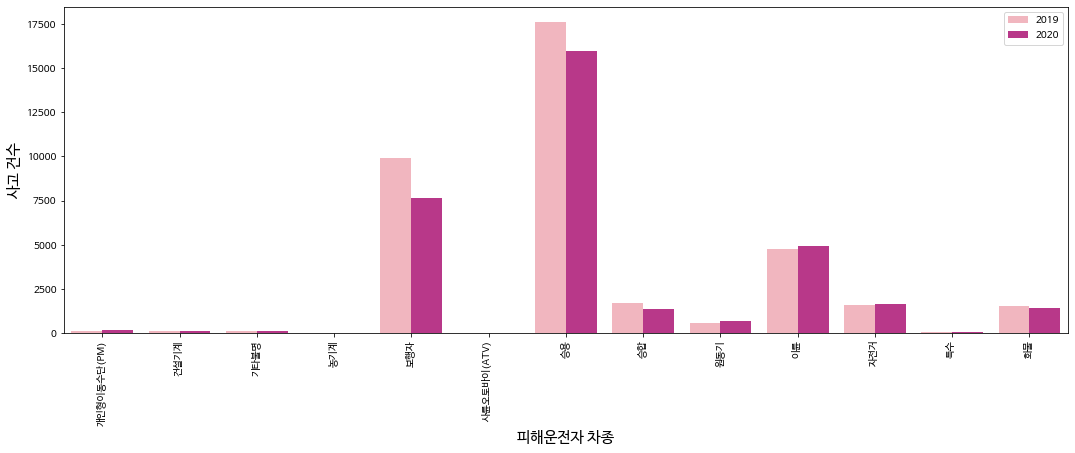

In [149]:
viz_by_category(df_acci, '피해운전자 차종')

사고를 유발한 가해운전자 차종을 보면 사고건수가 가장 많은 '승용'의 경우 2019년 대비 2020년 사고 건수가 줄어 들지만 '이륜','원동기','자전거','개인형이동수단(PM)'의 경우 사고건수가 비슷한 수준으로 유지되거나 증가하는 경향을 보임  



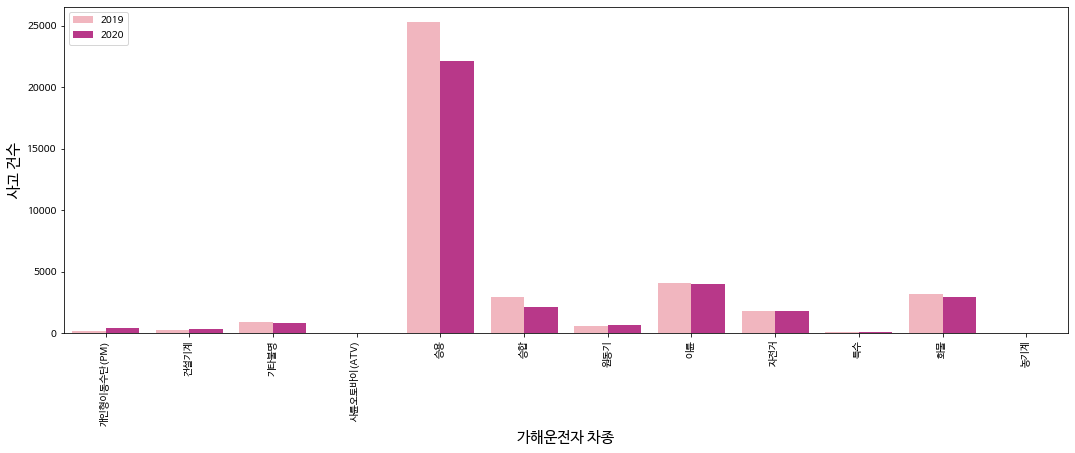

In [150]:
viz_by_category(df_acci, '가해운전자 차종')

추정되는 원인으로는 아래와 같음 <br>
(1) 사회적 거리두기 시행 이후로 재택근무, 비대면 식사등으로 인한 배달 이용이 증가하였으며([통계청 자료](https://kosis.kr/statHtml/statHtml.do?orgId=114&tblId=DT_114054_016))<br>
(2) 배달 건수 증가로 인한 이륜차 이용 증가([통계청 자료](https://kosis.kr/statHtml/statHtml.do?orgId=116&tblId=DT_MLTM_2042)), 그에 따른 이륜차 사고의 증가로 이어짐

In [12]:
#배달앱 사용 현황 데이터 load
df_delivery = pd.read_csv(data_dir+'배달앱_및_배달대행_이용현황_20210822144217.csv', encoding='euc-kr')

In [13]:
#배달앱 사용 현황 데이터 전처리
for i in df_delivery:
  if df_delivery[i][0] == '배달대행':
    df_delivery.drop(columns=i, inplace=True)

df_delivery.drop(index=0, inplace=True)

for i, x in df_delivery.iterrows():
  if x['특성별(3)'] == '기타 음식점업':
    x['특성별(3)'] = x['특성별(4)']

df_delivery.drop(columns=['특성별(4)'], inplace=True)

for i, x in df_delivery.iterrows():
  if x['특성별(3)'] == '소계':
    x['특성별(3)'] = x['특성별(1)'] + '-' + x['특성별(2)']

df_delivery.drop(columns=['특성별(1)'], inplace=True)
df_delivery.drop(columns=['특성별(2)'], inplace=True)

df_delivery_T = df_delivery.T

df_delivery_T.rename(columns=df_delivery_T.iloc[0], inplace=True)
df_delivery_T.drop(index='특성별(3)', inplace=True)
df_delivery_T['time'] = df_delivery_T.index
df_delivery_T.reset_index(drop=True, inplace=True)

df_delivery_T['time'] = df_delivery_T['time'].apply(lambda x : x.split('.')[0])

df_delivery_T.columns = ['특성별1', '특성별2', '전체-소계', '업종별-일반음식점', '한식', '중식', '일식', '서양식',
       '기타 외국식', '업종별-일반음식점 외', '기관 구내식당업', '출장·이동음식점업', '제과점',
       '피자·햄버거·샌드위치 및 유사 음식점업', '치킨전문점', '김밥 및 기타 간이 음식점업', '간이 음식 포장 판매 전문점',
       '주점업', '비알콜 음료점업', '운영형태별-프랜차이즈', '운영형태별-비프랜차이즈', '지역별-서울권', '지역별-수도권',
       '지역별-충청권', '지역별-호남권', '지역별-경남권', '지역별-경북권', '매출액규모별-5천만원 미만',
       '매출액규모별-5천만원~1억원 미만', '매출액규모별-1억원~5억원 미만', '매출액규모별-5억원 이상', 'time']

df_delivery_T['기관 구내식당업'] = df_delivery_T['기관 구내식당업'].replace('-', np.nan)
df_delivery_T['출장·이동음식점업'] = df_delivery_T['출장·이동음식점업'].replace('-', np.nan)

for i in df_delivery_T.columns[2:-1]:
  df_delivery_T[i] = df_delivery_T[i].astype('float64')

배달앱 이용 현황에서는 2018년 이후 배달앱 사용에 대해서 사용한다는 응답(예)이 증가해왔고, 월 평균 이용금액도 2018년 대비 40% 증가했음

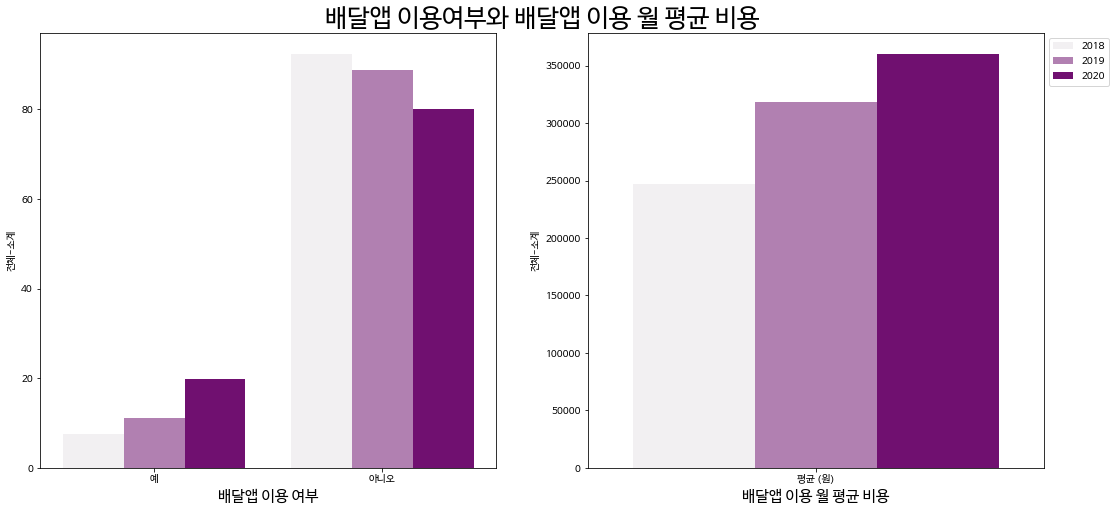

In [120]:
fig = plt.figure(figsize=(18,8))

plt.title('배달앱 이용여부와 배달앱 이용 월 평균 비용', fontdict={'fontsize' : 25})

plt.axis('off')
ax = fig.add_subplot(1, 2, 1)
sns.barplot(data=df_delivery_T[df_delivery_T['특성별1']=='이용여부 (%)'], 
          x='특성별2', y='전체-소계', 
          hue='time',
          color='purple')
plt.xlabel('배달앱 이용 여부', fontdict={'fontsize' : 15})
plt.legend([],[], frameon=False)

ax = fig.add_subplot(1, 2, 2)
sns.barplot(data=df_delivery_T[df_delivery_T['특성별2']=='평균 (원)'], 
          x='특성별2', y='전체-소계', 
          hue='time',
          color='purple')

plt.xlabel('배달앱 이용 월 평균 비용', fontdict={'fontsize' : 15})
plt.legend(bbox_to_anchor=(1, 1))

plt.show()

In [ ]:
#이륜차 신고 현황 데이터 load
df_2wheel = pd.read_csv(data_dir+'이륜차신고현황_연도별_20210822144233.csv', encoding='euc-kr')

In [ ]:
#이륜차 신고 현황 데이터 전처리
df_2wheel = df_2wheel.T
df_2wheel.iloc[1, :]
df_2wheel.rename(columns=df_2wheel.iloc[1], inplace=True)
df_2wheel.drop(index='구분(1)', inplace=True)
df_2wheel.drop(index='레벨01(1)', inplace=True)

for i in df_2wheel.columns[1:]:
  df_2wheel[i] = df_2wheel[i].apply(lambda x : int(x))

df_2wheel['time'] = df_2wheel.index
df_2wheel.reset_index(drop=True, inplace=True)

for i, x in enumerate(df_2wheel['time']):
  if '.' in x:
    df_2wheel['time'][i] = x.split('.')[0]

전체적으로 2018년 이후 50cc미만부터 250cc초과까지 모든 이륜차에 대한 차량 등록 신고건수는 증가해왔음

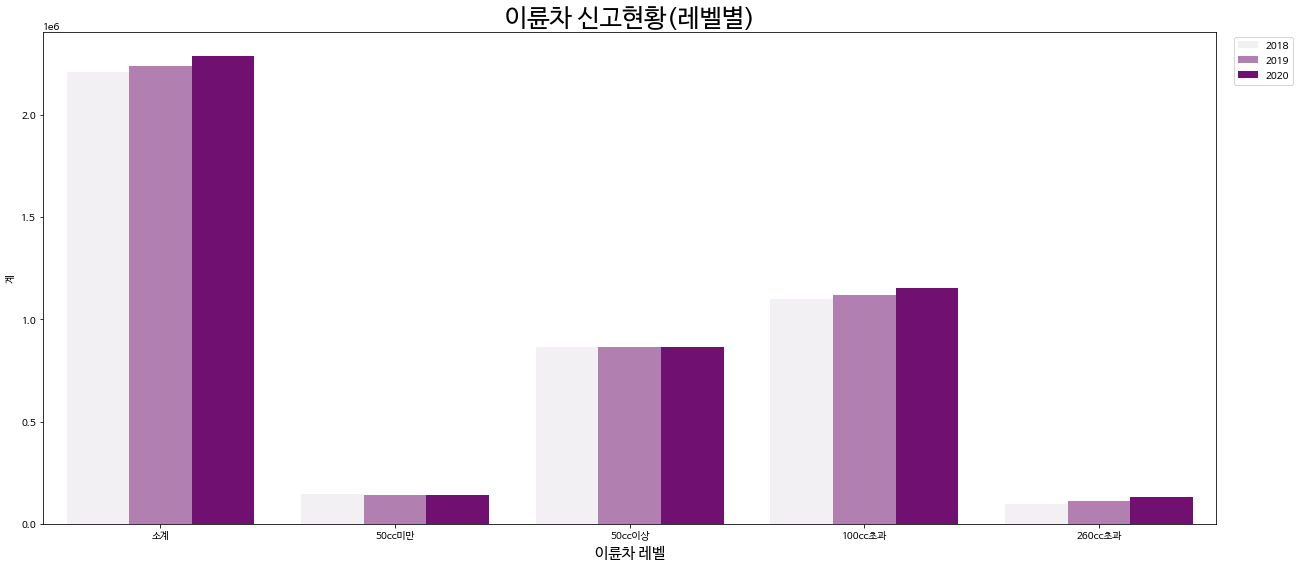

In [119]:
plt.figure(figsize=(18,8))
plt.title('이륜차 신고현황(레벨별)', fontdict={'fontsize' : 25})
sns.barplot(data=df_2wheel, 
            x='레벨01(1)', y='계', 
            hue='time', color='purple')
plt.legend(bbox_to_anchor=(1.07, 1))
plt.xlabel('이륜차 레벨', fontdict={'fontsize' : 15})
plt.tight_layout()
plt.show()

그런데 이 두바퀴들이 일으킨 사고의 주요 피해자는?


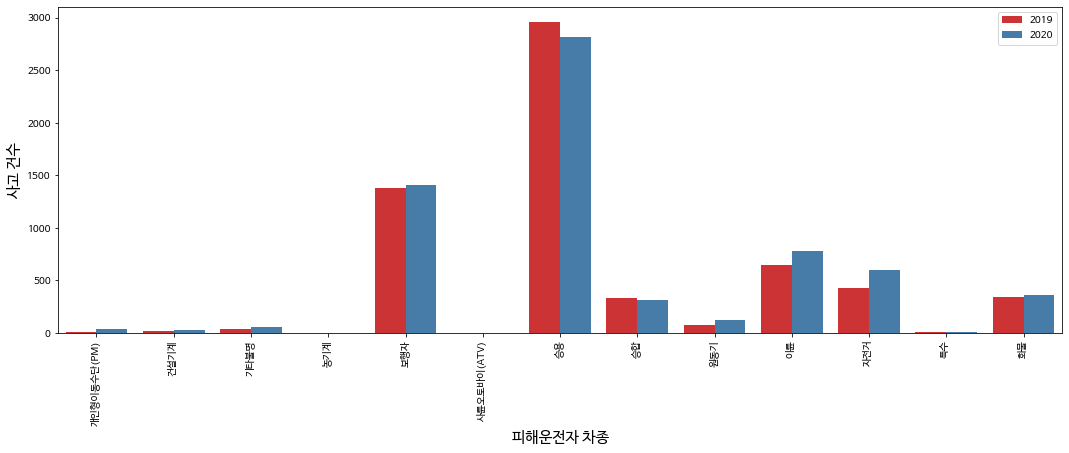

In [147]:
df_new = pd.DataFrame(df_acci[df_acci['가해운전자 차종'].isin(['이륜','원동기','자전거','개인형이동수단(PM)'])].groupby(['연도', '피해운전자 차종'])['사고유형'].count())

df_new['연도'] = df_new.index.get_level_values(0)
df_new['피해운전자 차종'] = df_new.index.get_level_values(1)


plt.figure(figsize=(18,6))
sns.barplot(data=df_new,
          x='피해운전자 차종',
          y='사고유형',
          hue='연도', palette='Set1')
plt.xticks(rotation=90)
plt.ylabel('사고 건수', fontdict={'fontsize' : 15})
plt.xlabel('피해운전자 차종', fontdict={'fontsize' : 15})
plt.legend(loc='best')
plt.show()

이륜차 사고에 대해서 조금 더 세부적으로 분석해보면 아래와 같다.
여기서 이륜차는 다음을 포함한다.
- 이륜(125cc이상)
- 원동기(125cc미만)
- 자전거

In [96]:
#이륜차 사고만 추출한 데이터
mask = (df_acci['가해운전자 차종']==('원동기')) | (df_acci['가해운전자 차종']==('이륜')) | (df_acci['가해운전자 차종']==('자전거'))
df_acci_2wheel = df_acci.loc[mask, :]

1. `안전운전불이행` 법규를 위반한 사례가 가장 늘었다.

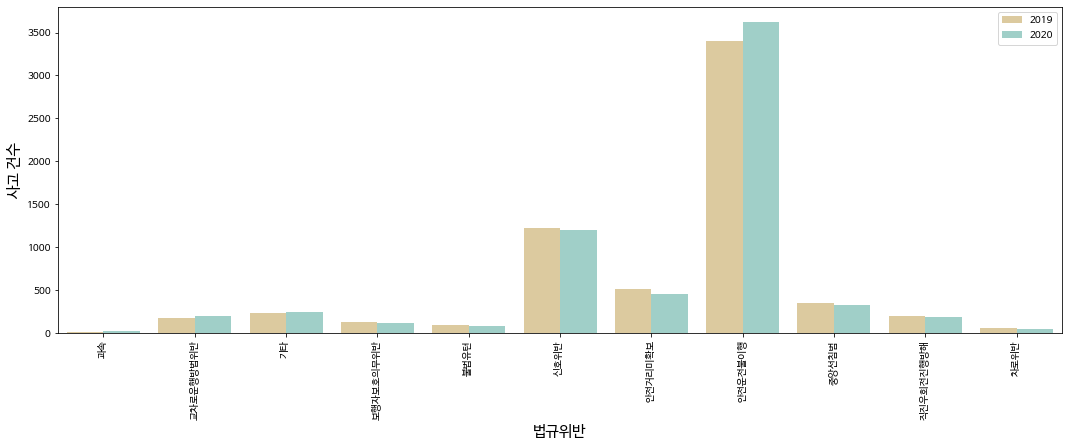

In [151]:
viz_by_category(df_acci_2wheel, '법규위반', palette='BrBG')

2. 가해운전자/피해운전자 모두 `20대, 30대` `이륜, 승용`이 가장 많이 늘었다.

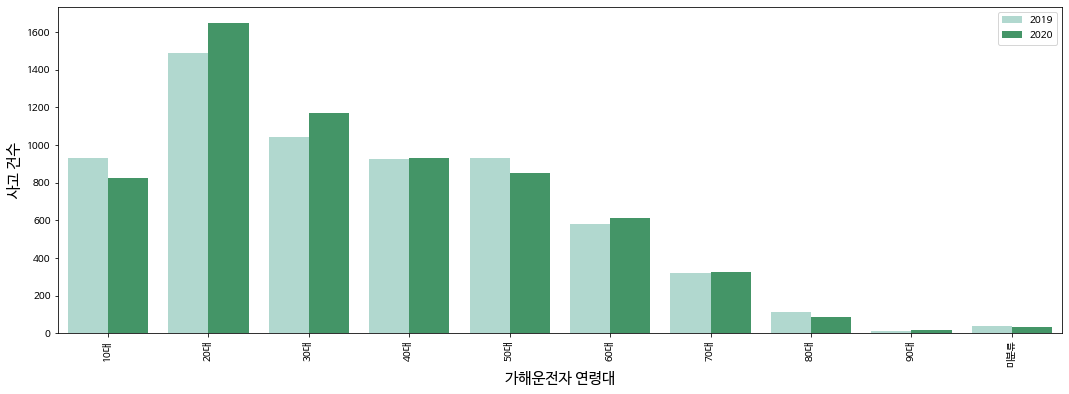

In [152]:
viz_by_category(df_acci_2wheel, '가해운전자 연령대', palette='BuGn')

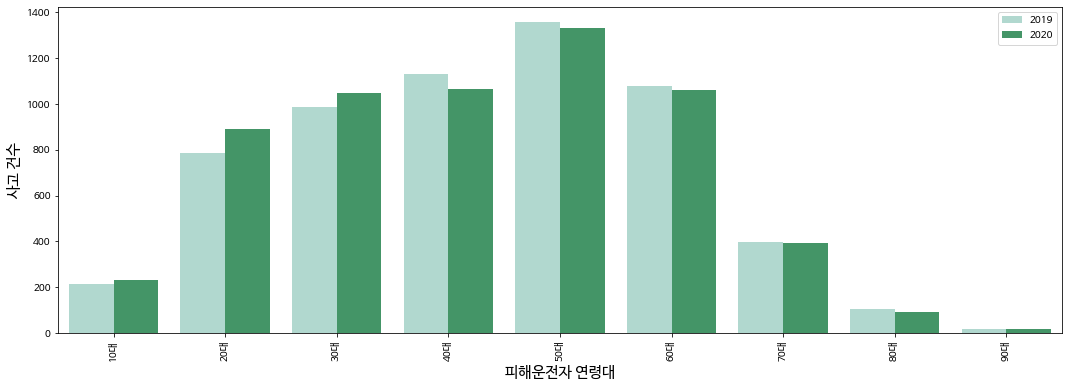

In [153]:
viz_by_category(df_acci_2wheel, '피해운전자 연령대', palette='BuGn')

3. 사고 시간대는 12시, 18시로 `식사시간대`가 크게 증가했다.

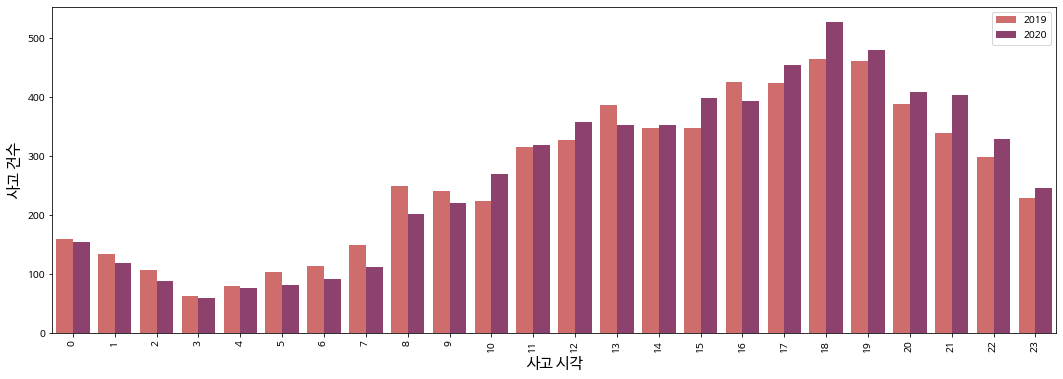

In [154]:
viz_by_category(df_acci_2wheel, '사고 시각', palette='flare')

전체에서는 보행자사고는 줄었지만 이륜, 자전거 등에 의한 보행자 사고는 오히려 증가한 것을 알 수 있음
그럼 이번에는 서울시의 25개 구별로 더 자세히 살펴봅시다

### 1.2. 서울시 자치구별 교통사고 



비슷한 방법으로 자치구별로 나눠서 다루고  

특히 3~4개 자치구를 정해서 얘네는 동별로 다시 쪼개서  
강남구, 서초구, 송파구 등등 주로 강 남쪽 자치구들


In [138]:
# 데이터 groupby
df_acci_gu = pd.DataFrame(df_acci.groupby(['연도', '구'])['사고유형'].count())
df_acci_gu['연도'] = df_acci_gu.index.get_level_values(0)
df_acci_gu['구'] = df_acci_gu.index.get_level_values(1)

서울특별시 자치구 별로 교통사고 건수를 살펴보면 `강남구, 관악구, 성동구`가 유일하게 증가했다.

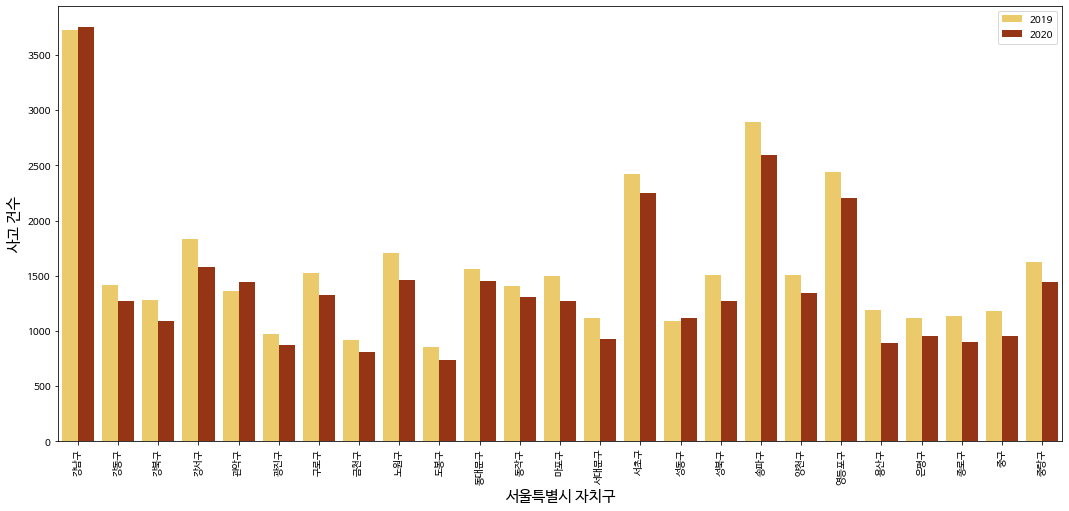

In [163]:
plt.figure(figsize=(18,8))
sns.barplot(data=df_acci_gu[df_acci_gu['구']!='미분류'],
            x='구',
            y='사고유형',
            hue='연도', palette="afmhot_r")
plt.xticks(rotation=90)
plt.ylabel('사고 건수', fontdict={'fontsize' : 15})
plt.xlabel('서울특별시 자치구', fontdict={'fontsize' : 15})
plt.legend(loc='best')
plt.show()

In [145]:
#동별 분석을 위한 groupby
df_acci_dong = pd.DataFrame(df_acci.groupby(['연도', '구', '동'])['사고유형'].count())
df_acci_dong['연도'] = df_acci_dong.index.get_level_values(0)
df_acci_dong['구'] = df_acci_dong.index.get_level_values(1)
df_acci_dong['동'] = df_acci_dong.index.get_level_values(2)

위에서 증가한 세 구(강남구, 관악구, 성동구)만 동별로 다시 살펴보면,
1. 강남구는 역삼동, 논현동, 대치동 순으로 건수가 가장 많았으며, 역삼동, 삼성동, 도곡동 순으로 전년대비 증가율이 높았다.

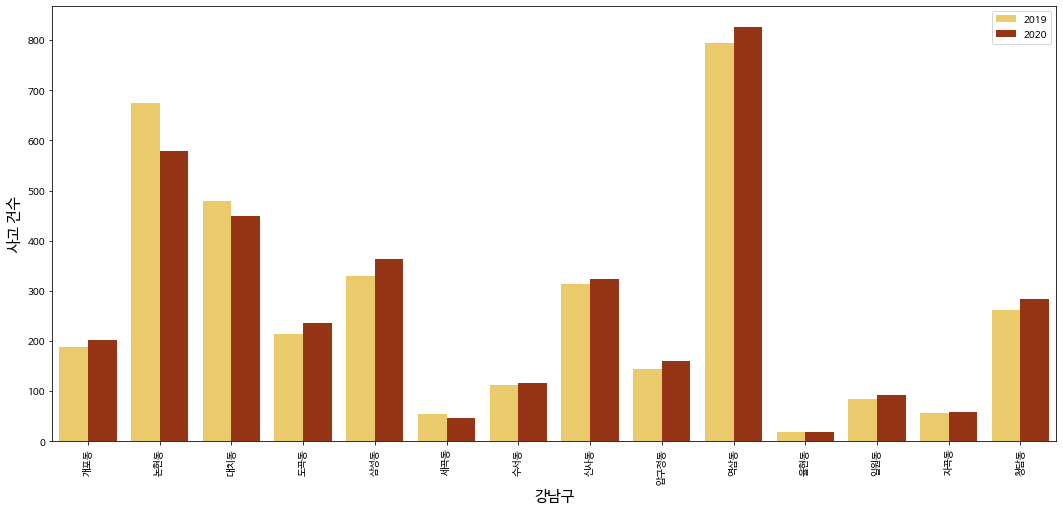

In [164]:
plt.figure(figsize=(18,8))
sns.barplot(data=df_acci_dong[df_acci_dong['구']=='강남구'],
            x='동',
            y='사고유형',
            hue='연도', palette="afmhot_r")
plt.xticks(rotation=90)
plt.ylabel('사고 건수', fontdict={'fontsize' : 15})
plt.xlabel('강남구', fontdict={'fontsize' : 15})
plt.legend(loc='best')
plt.show()

2. 서초구는 서초동, 반포동, 방배동 순으로 건수가 가장 많았으며, 잠원동이 유일하게 전년대비 증가하였다.

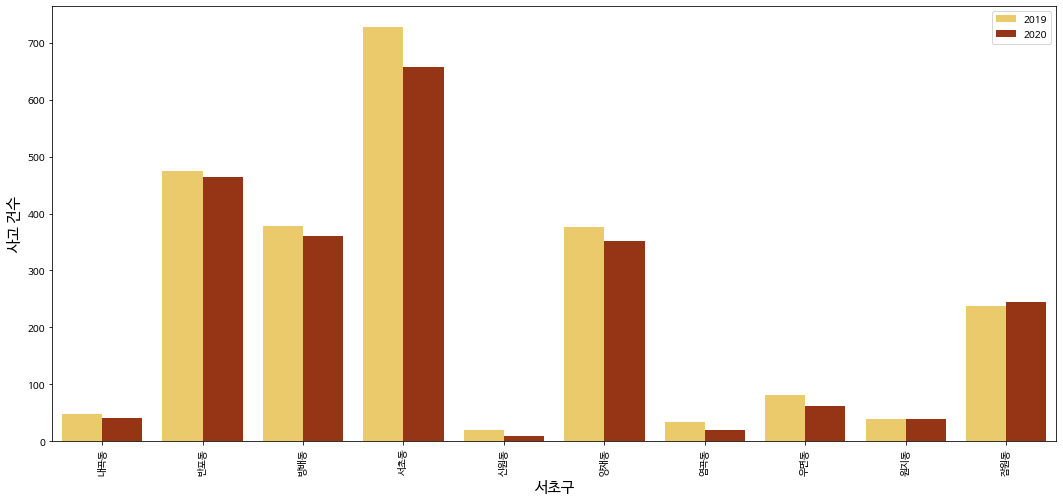

In [165]:
plt.figure(figsize=(18,8))
sns.barplot(data=df_acci_dong[df_acci_dong['구']=='서초구'],
            x='동',
            y='사고유형',
            hue='연도', palette="afmhot_r")
plt.xticks(rotation=90)
plt.ylabel('사고 건수', fontdict={'fontsize' : 15})
plt.xlabel('서초구', fontdict={'fontsize' : 15})
plt.legend(loc='best')
plt.show()

3. 성동구는 성수동1가, 2가, 행당동 순으로 건수가 가장 많았으며, 성수동2가와 마장동, 행당동순으로 전년대비 증가율이 높았다. 특히나 성수동2가의 교통사고 증가율은 눈에 띄게 늘었다.

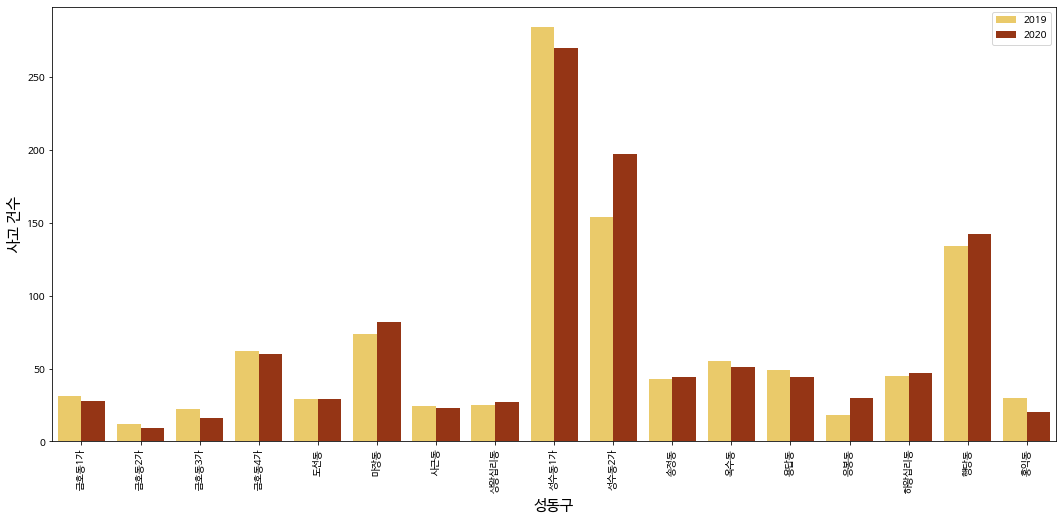

In [166]:
plt.figure(figsize=(18,8))
sns.barplot(data=df_acci_dong[df_acci_dong['구']=='성동구'],
            x='동',
            y='사고유형',
            hue='연도', palette="afmhot_r")
plt.xticks(rotation=90)
plt.ylabel('사고 건수', fontdict={'fontsize' : 15})
plt.xlabel('성동구', fontdict={'fontsize' : 15})
plt.legend(loc='best')
plt.show()

## 2. 도로 및 건물 특성에 따른 사고 발생

1.에서 살펴본 것과 같이 행정구역, 위치별로 발생하는 교통사고의 특성의 차이가 있음.  
고속도로는 도로위의 주체가 모두 차량이라서 사고가 발생하는 위치를 파악하는 것만으로도 대응하기 편하지만 시내교통은 다름.  
단순히 사고 발생이 많다는 것을 확인하는 것 뿐만 아니라 왜 사고가 발생하는지 다양한 예상 원인을 확인할 필요가 있음.  

먼저 도로 자체의 특성이나 주변 건물 특성에 따른 사고의 차이를 확인하려고 함. 계획된 도시는 건물과 도로를 함께 계획. 오래된 도시는 도로는 그대로인데, 주변 건물이 발달하면서 도로 정체가 심해지고 사고 발생 위험이 커질 수 있음. 



### 2.1. 도로 면적에 따른 차이

새롭게 만들어진 지역은 상대적으로 도로가 넓고 잘 정비되어 있음. 

In [ ]:
# 자치구별 도로 면적 및 폭별 연장
df_road = pd.read_csv('../data/road.csv', encoding='UTF-8')
df_road.drop(0,axis=0,inplace=True)
df_road = df_road.sort_values(by='자치구')
df_road.reset_index(drop=True, inplace=True)

,자치구,연장,면적,광로,대로,중로,소로
0,강남구,434999,5698444,35575,30825,63721,304878
1,강동구,290189,3541933,13462,27456,42777,206494
2,강북구,227266,1982644,0,15923,30408,180935
3,강서구,410852,5032589,24369,45649,66911,273923
4,관악구,322203,3028487,11597,15485,30437,264684
5,광진구,324615,3436438,3700,30458,23288,267169
6,구로구,294701,3177759,9197,32898,28740,223866
7,금천구,190998,2252507,6809,9569,39494,135126
8,노원구,296279,3841026,0,55479,54457,186343
9,도봉구,257745,2354214,5900,17075,24716,210054


In [ ]:
# 전체 사고건수
df_temp = pd.DataFrame(pd.pivot_table(df_acci[(df_acci['연도']==2020)],
                                                index= '구',
                                                values='사고유형',
                                                aggfunc='count'))['사고유형']
df_temp.reset_index(drop=True, inplace=True)


In [ ]:
# 이륜사고건수
df_temp2 = pd.DataFrame(pd.pivot_table(df_acci[(df_acci['연도']==2020)&df_acci['가해운전자 차종'].isin(['이륜','원동기','자전거','개인형이동수단(PM)'])],
                                                index= '구',
                                                values='사고유형',
                                                aggfunc='count'))
df_temp2.reset_index(drop=True, inplace=True)
df_temp2.rename(columns = {'사고유형':'이륜사고건수'}, inplace=True)


In [ ]:
df_road2 = pd.concat([df_road, df_temp, df_temp2], axis=1) 
df_road2.rename(columns = {'사고유형':'사고건수'}, inplace=True)
df_road2


,자치구,연장,면적,광로,대로,중로,소로,사고건수,이륜사고건수
0,강남구,434999,5698444,35575,30825,63721,304878,3752,527
1,강동구,290189,3541933,13462,27456,42777,206494,1268,216
2,강북구,227266,1982644,0,15923,30408,180935,1087,252
3,강서구,410852,5032589,24369,45649,66911,273923,1575,309
4,관악구,322203,3028487,11597,15485,30437,264684,1444,287
5,광진구,324615,3436438,3700,30458,23288,267169,869,202
6,구로구,294701,3177759,9197,32898,28740,223866,1325,248
7,금천구,190998,2252507,6809,9569,39494,135126,810,148
8,노원구,296279,3841026,0,55479,54457,186343,1462,303
9,도봉구,257745,2354214,5900,17075,24716,210054,741,187



너무나 당연하게도 전반적으로 도로의 면적이 넓을 수록, 사고 건수가 많은 것을 확인할 수 있습니다.
`이거 점 대신 글자로 찍는거 loop를 쓸 수밖에 없나요?`



<AxesSubplot:xlabel='면적', ylabel='사고건수'>

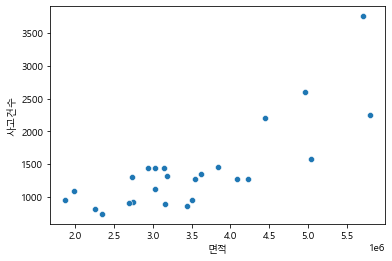

In [ ]:
# 산점도1
sns.scatterplot(data=df_road2, x="면적", y="사고건수", )

그런데 이륜 관련 사고건수만 살펴보면, 도로 면적과는 일부 관계가 있어보이지만, 도로의 폭과는 큰 관계가 없어보임.  


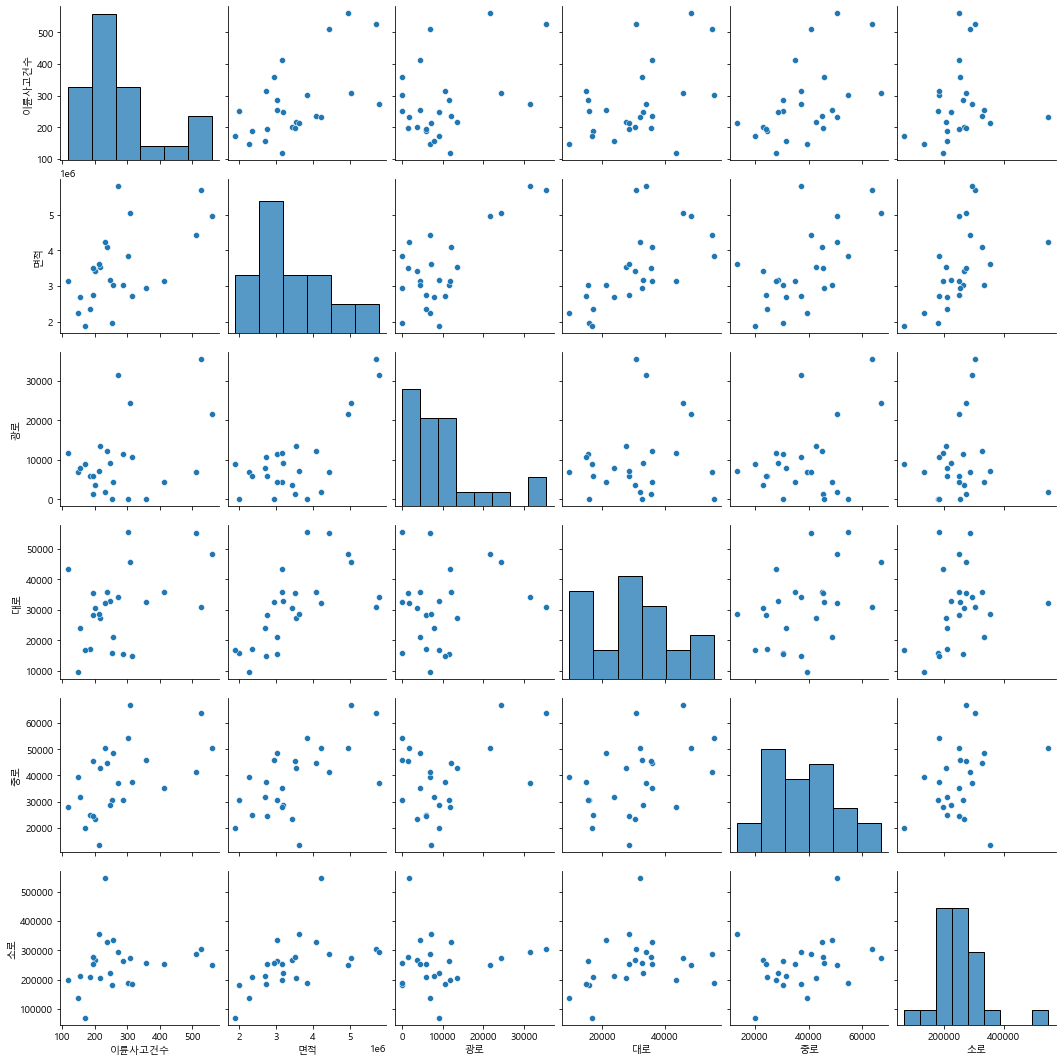

In [ ]:
# pairplot
sns.pairplot(df_road2.iloc[:,[8,2,3,4,5,6]])


In [ ]:
df_new = pd.DataFrame(df_acci[(df_acci['연도']==2020) & (df_acci['가해운전자 차종'].isin(['이륜','원동기','자전거','개인형이동수단(PM)'])) & df_acci['피해운전자 차종'].isin(['보행자','승용','이륜','자전거'])])
df_agg1 = pd.pivot_table(df_new,
               index = ['구'], 
               columns=['피해운전자 차종'], values='사고유형', aggfunc='count')

# df_new

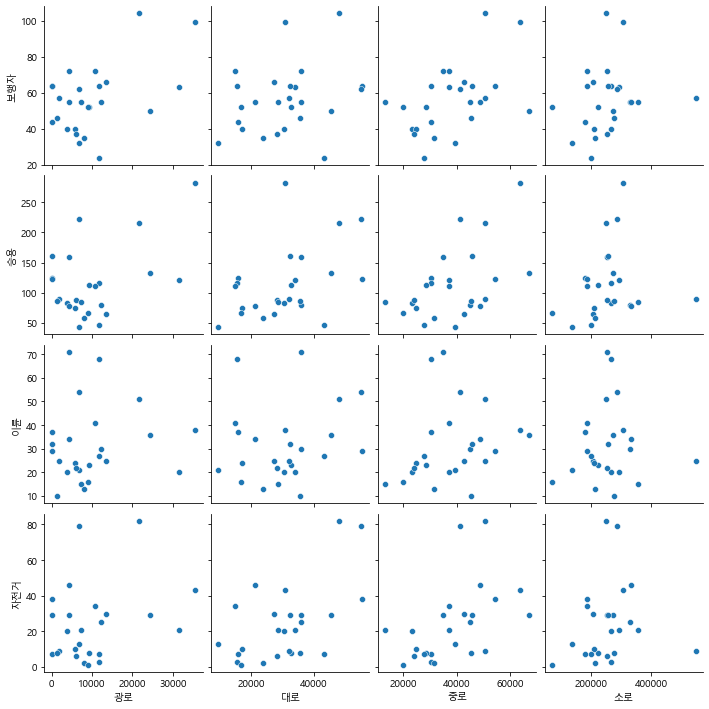

In [ ]:
df_agg1.reset_index(drop=True, inplace=True)
df_road3 = pd.concat([df_road.iloc[:,[0, 3,4,5,6]], df_agg1], axis=1) 
df_road3

sns.pairplot(df_road3, x_vars=['광로', '대로', '중로', '소로'], y_vars=['보행자','승용','이륜','자전거'])



In [ ]:
# df_agg1[['보행자', '승용', '이륜', '자전거']] = df_agg1[['보행자', '승용', '이륜', '자전거']].apply(lambda x: x/x.sum(), axis=1)
# df_agg1.reset_index(drop=True, inplace=True)

# df_road[['광로R', '대로R', '중로R', '소로R']] = df_road[['광로', '대로', '중로', '소로']].apply(lambda x: x/x.sum(), axis=1)

# df_road3 = pd.concat([df_road.iloc[:,[0, 7,8,9,10]], df_agg1], axis=1) 
# # df_road2.rename(columns = {'사고유형':'사고건수'}, inplace=True)
# df_road3

# # pairplot
# sns.pairplot(df_road3.iloc[:,1:9], x_vars=['광로R', '대로R', '중로R', '소로R'], y_vars=['보행자','승용','이륜','자전거'])



,자치구,광로R,대로R,중로R,소로R,보행자,승용,이륜,자전거
0,강남구,0.081782,0.070862,0.146485,0.700871,0.213823,0.611231,0.082073,0.092873
1,강동구,0.046390,0.094614,0.147411,0.711585,0.356757,0.345946,0.135135,0.162162
2,강북구,0.000000,0.070063,0.133799,0.796138,0.207547,0.584906,0.174528,0.033019
3,강서구,0.059313,0.111108,0.162859,0.666719,0.202429,0.534413,0.145749,0.117409
4,관악구,0.035993,0.048060,0.094465,0.821482,0.254980,0.462151,0.270916,0.011952
5,광진구,0.011398,0.093828,0.071740,0.823033,0.245399,0.509202,0.122699,0.122699
6,구로구,0.031208,0.111632,0.097523,0.759638,0.266667,0.574359,0.117949,0.041026
7,금천구,0.035650,0.050100,0.206777,0.707473,0.293578,0.394495,0.192661,0.119266
8,노원구,0.000000,0.187253,0.183803,0.628944,0.252964,0.482213,0.114625,0.150198
9,도봉구,0.022891,0.066248,0.095893,0.814968,0.268456,0.503356,0.161074,0.067114


이륜 관련 사고의 피해자를 각 구별 도로 크기 연장과 관계를 살펴봐도 큰 관계가 없어 보임  
이렇게 구처럼 큰 단위의 분석보다는 동 단위의 분석이 필요.  
동별 인구나 건물 구성에 따른 사고 발생의 차이를 살펴보려고 함. 

### 2.2. 건물 연면적에 따른 차이

아쉽게도 도로 면적은 서울시의 자치구 단위로만 제공.  
법정동 단위의 분석을 위해서는 또다른 정보가 필요한데, 그래서 활용한 것이 표제부 데이터  

법정동별로 건물의 주사용목적코드에 따라 건물들의 연면적 합계를 계산함. 대지면적과 달리 연면적은 건물의 부피의 개념을 가지고 있으므로, 연면적이 클수록 해당 지역에 크고 높고 넓은 건물이 많다는 의미. 그리고 목적에 따라 사람이 몰릴 수도 있고, 차량이 몰릴 수도 있기 때문에 교통사고의 발생 가능성에 영향을 미칠 것이라고 판단. 

`실제로 아파트가 많은 지역, 업무시설이 많은 지역에 따른 차이가 있음`


In [ ]:
df_building = pd.read_csv('../data/building_agg.csv', encoding='UTF-8')

In [ ]:
df_building['주용도'] = [x if x in ['공동주택','업무시설','노유자시설','제1종근린생활시설','제2종근린생활시설'] else '기타' for x in df_building['주용도코드명']]
df_building

,dong_cd,시군구,법정동,주용도코드명,N,GFA,주용도
0,11680101,강남구,역삼동,제2종근린생활시설,1103,1.092966e+06,제2종근린생활시설
1,11680101,강남구,역삼동,제1종근린생활시설,532,5.671386e+05,제1종근린생활시설
2,11680101,강남구,역삼동,단독주택,1332,6.481129e+05,기타
3,11680101,강남구,역삼동,업무시설,565,4.914127e+06,업무시설
4,11680101,강남구,역삼동,공동주택,1156,2.297032e+06,공동주택
...,...,...,...,...,...,...,...
5742,11260106,중랑구,신내동,판매시설,4,3.232090e+04,기타
5743,11260106,중랑구,신내동,숙박시설,1,6.343600e+02,기타
5744,11260106,중랑구,신내동,문화및집회시설,1,4.563170e+03,기타
5745,11260106,중랑구,신내동,방송통신시설,2,8.236380e+03,기타


In [ ]:
df_building_agg1 = pd.DataFrame(pd.pivot_table(df_building, index='시군구', columns='주용도', values='GFA', aggfunc='sum'))

df_building_agg1[['공동주택','업무시설','노유자시설','제1종근린생활시설','제2종근린생활시설','기타']] = df_building_agg1[['공동주택','업무시설','노유자시설','제1종근린생활시설','제2종근린생활시설','기타']].apply(lambda x: x/x.sum(), axis=1)


df_building_agg1['시군구'] = df_building_agg1.index.get_level_values(0)
df_building_agg1.reset_index(drop=True, inplace=True)
  
df_building_agg1


주용도,공동주택,기타,노유자시설,업무시설,제1종근린생활시설,제2종근린생활시설,시군구
0,0.541459,0.134571,0.003473,0.198808,0.044270,0.077419,강남구
1,0.624017,0.210747,0.006185,0.055145,0.050410,0.053496,강동구
2,0.512546,0.316935,0.005843,0.027203,0.082565,0.054907,강북구
3,0.510611,0.283291,0.006738,0.111415,0.044717,0.043227,강서구
4,0.440728,0.348066,0.003856,0.049887,0.062764,0.094698,관악구
5,0.500734,0.310126,0.013138,0.047602,0.068229,0.060170,광진구
6,0.511749,0.320331,0.006047,0.084458,0.042935,0.034481,구로구
7,0.310530,0.544342,0.004137,0.053840,0.035973,0.051178,금천구
8,0.734849,0.179301,0.004565,0.017640,0.034869,0.028777,노원구
9,0.880922,0.070363,0.002323,0.011728,0.019672,0.014992,도봉구


In [ ]:
df_agg1 = pd.pivot_table(df_new,
               index = ['구'], 
               columns=['피해운전자 차종'], values='사고유형', aggfunc='count')


In [ ]:
df_agg1.reset_index(drop=True, inplace=True)
df_build_acci = pd.concat([df_building_agg1, df_agg1], axis=1) 
df_build_acci



,공동주택,기타,노유자시설,업무시설,제1종근린생활시설,제2종근린생활시설,시군구,보행자,승용,이륜,자전거
0,0.541459,0.134571,0.003473,0.198808,0.044270,0.077419,강남구,99,283,38,43
1,0.624017,0.210747,0.006185,0.055145,0.050410,0.053496,강동구,66,64,25,30
2,0.512546,0.316935,0.005843,0.027203,0.082565,0.054907,강북구,44,124,37,7
3,0.510611,0.283291,0.006738,0.111415,0.044717,0.043227,강서구,50,132,36,29
4,0.440728,0.348066,0.003856,0.049887,0.062764,0.094698,관악구,64,116,68,3
5,0.500734,0.310126,0.013138,0.047602,0.068229,0.060170,광진구,40,83,20,20
6,0.511749,0.320331,0.006047,0.084458,0.042935,0.034481,구로구,52,112,23,8
7,0.310530,0.544342,0.004137,0.053840,0.035973,0.051178,금천구,32,43,21,13
8,0.734849,0.179301,0.004565,0.017640,0.034869,0.028777,노원구,64,122,29,38
9,0.880922,0.070363,0.002323,0.011728,0.019672,0.014992,도봉구,40,75,24,10


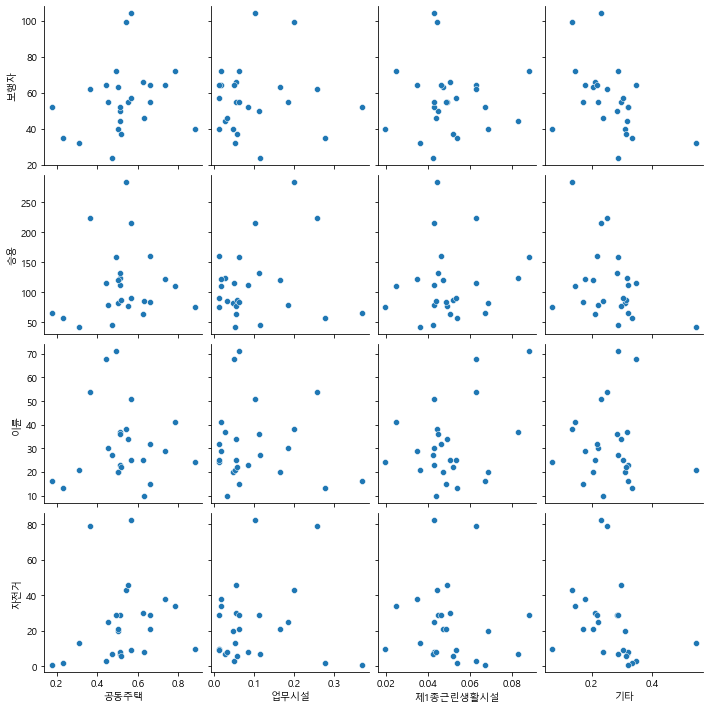

In [ ]:
# pairplot
sns.pairplot(df_build_acci, x_vars=['공동주택', '업무시설', '제1종근린생활시설', '기타'], y_vars=['보행자','승용','이륜','자전거'])


### 2.3. 법정동별 건물 연면적과 사고 발생

`이륜차나 차대차-기타에 집중하면 어떤 법정동에서 사고가 많이 발생하는지와 해당 법정동의 건물 특성을 활용 가능`

`비슷한 건물 구성을 가졌으나 사고 차이가 있는 법정동을 가져와서 로드뷰 같은 걸로 비교 가능`

## 3. 유동인구와 사고 발생

건물이 있다고 해서 무조건 사고가 발생하는 것은 아님.  
뻥뚤린 도로에서 사고는 발생하지 않음. 도로가 복잡해져야 사고가 발생함.  

공유된 데이터로는 시내 교통에서 특정 시점 특정 지역의 차량수를 파악하는것은 어려움.  
대신 통신사 기지국 정보 기반 생활인구 데이터, 대중교통 이용 데이터 등을 활용해서 유추 가능.  

`위의 분석들과 엮어서 유동인구가 많을 때 사고가 많이 난다는 것을 보여야 함`

`차대 사람 사고  - 법정동별 차이로 가도 되고, 특정 시간에 사고가 많이 발생하는 한 두 법정동을 잡아두고, 사고 발생과 유동인구를 엮기`

`이륜차 사고 - 이륜차는 배달 중심일 테니까, 건물 정보를 봤을 때 공동주택(아파트)가 많은 지역 중에서 2019년 대비 2020 생활인구가 많이 늘어난 법정동을 잡고, 엮기`



### 3.1. 000의 인구와 사고 발생 

`위의 예시 중에서 선택된 첫번째꺼`

### 3.2. 000의 인구와 사고 발생 

`위의 예시 중에서 선택된 두번째꺼`

## 4. 통합 분석

도로의 사고와 건물, 인구 정보를 결합해서 살펴봤음. 

`여기서 특정 두 지역을 전체적으로 비교하는 것도 좋을 듯`


### 4.1. 대표적인 두 지역의 비교 

`사례 중심`

### 4.2. 사고 발생가능성 높은 지역 

`이륜차 등으로 범위를 잡은 다음에 사고 발생 가능성이 높을 것 같은 위험 지역 들을 선정`

## 5. 마무리 


`확인 한 것들 정리`

`확인 한 것으로 활용 가능한 것 : 대부분 "사고를 줄이려면?"`

`위험 지역에 대한 이륜차 등 단속 강화, 보행자 안전 확보를 위해 필요한 장치 등`
